### UAS Deep Learning Case 1 with Attention
Nama : Patrick Jonathan

NIM : 2440064791

In [ ]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import os
import random
import cv2
import tensorflow as tf
from tensorflow.python.keras.models import Sequential
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.python.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.layers import Conv2D, BatchNormalization, Activation, MaxPool2D, Conv2DTranspose, Concatenate, Input, Dropout, Add, Multiply
from tensorflow.keras.models import Model

In [ ]:
! unzip Aerial-Image-Dataset.zip

Streaming output truncated to the last 5000 lines.
  inflating: Forest Segmented/Forest Segmented/masks/119079_mask_73.jpg  
  inflating: Forest Segmented/Forest Segmented/masks/119079_mask_77.jpg  
  inflating: Forest Segmented/Forest Segmented/masks/119079_mask_78.jpg  
  inflating: Forest Segmented/Forest Segmented/masks/119079_mask_80.jpg  
  inflating: Forest Segmented/Forest Segmented/masks/119079_mask_81.jpg  
  inflating: Forest Segmented/Forest Segmented/masks/119079_mask_87.jpg  
  inflating: Forest Segmented/Forest Segmented/masks/119079_mask_88.jpg  
  inflating: Forest Segmented/Forest Segmented/masks/122104_mask_00.jpg  
  inflating: Forest Segmented/Forest Segmented/masks/122104_mask_01.jpg  
  inflating: Forest Segmented/Forest Segmented/masks/122104_mask_03.jpg  
  inflating: Forest Segmented/Forest Segmented/masks/122104_mask_04.jpg  
  inflating: Forest Segmented/Forest Segmented/masks/122104_mask_11.jpg  
  inflating: Forest Segmented/Forest Segmented/masks/122104_m

In [ ]:
base_directory = './Forest Segmented/Forest Segmented'
images_folder = os.path.join(base_directory, 'images')
masks_folder = os.path.join(base_directory, 'masks')
data = pd.read_csv(os.path.join(base_directory, 'meta_data.csv'))

In [ ]:
data.head()

,image,mask
0,10452_sat_08.jpg,10452_mask_08.jpg
1,10452_sat_18.jpg,10452_mask_18.jpg
2,111335_sat_00.jpg,111335_mask_00.jpg
3,111335_sat_01.jpg,111335_mask_01.jpg
4,111335_sat_02.jpg,111335_mask_02.jpg


In [ ]:
img_dim = 256

image_datagen = ImageDataGenerator(rescale=1./255,validation_split=0.15)
mask_datagen = ImageDataGenerator(rescale=1./255,validation_split=0.15)

train_image_generator = image_datagen.flow_from_directory(
        './Forest Segmented/Forest Segmented',
        target_size=(img_dim, img_dim),
        class_mode = None,
        classes = ['images'],
        batch_size = 32,
        seed=42,
        subset='training')
    
train_mask_generator = mask_datagen.flow_from_directory(
        './Forest Segmented/Forest Segmented',
        target_size=(img_dim, img_dim),
        class_mode = None,
        classes = ['masks'],
        color_mode = 'grayscale',
        batch_size = 32,
        seed=42,
        subset='training')

val_image_generator = image_datagen.flow_from_directory(
        './Forest Segmented/Forest Segmented',
        target_size=(img_dim, img_dim),
        class_mode = None,
        classes = ['images'],
        batch_size = 32,
        seed=42,
        subset='validation')
    
val_mask_generator = mask_datagen.flow_from_directory(
        './Forest Segmented/Forest Segmented',
        target_size=(img_dim, img_dim),
        class_mode = None,
        classes = ['masks'],
        color_mode = 'grayscale',
        batch_size = 32,
        seed=42,
        subset='validation')

train_generator = zip(train_image_generator, train_mask_generator)
val_generator = zip(val_image_generator, val_mask_generator)

Found 4342 images belonging to 1 classes.
Found 4342 images belonging to 1 classes.
Found 766 images belonging to 1 classes.
Found 766 images belonging to 1 classes.


In [ ]:
training_samples_size = train_image_generator.samples
val_samples_size = val_image_generator.samples

In [ ]:
print(training_samples_size)
print(val_samples_size)

4342
766


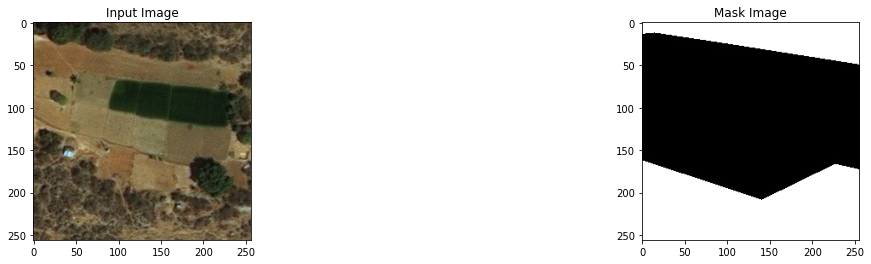

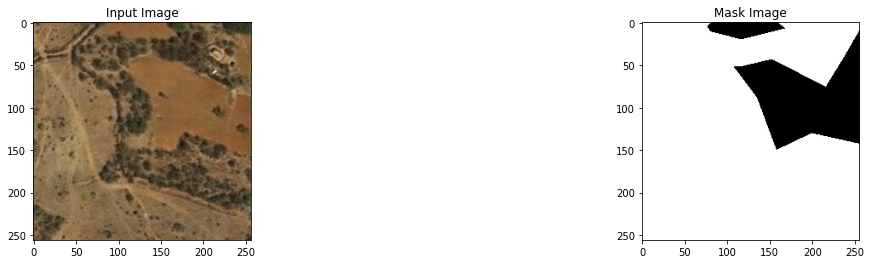

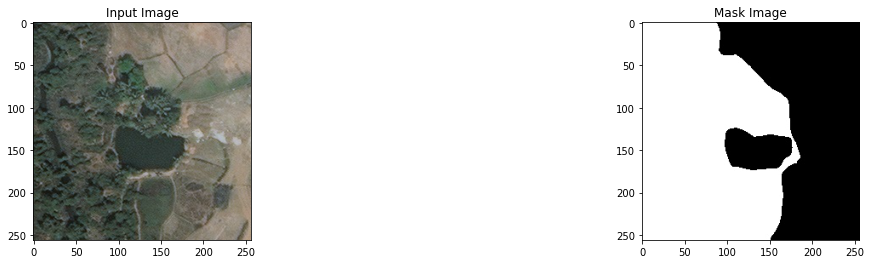

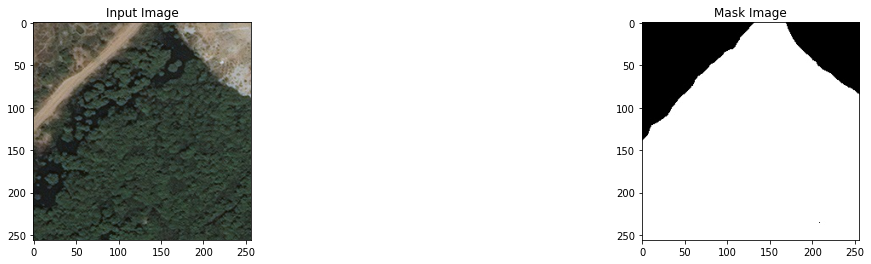

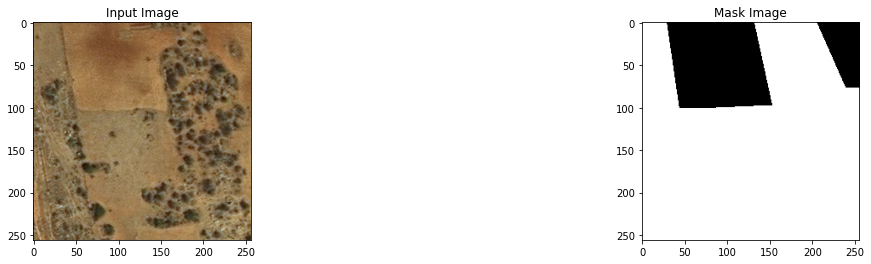

In [ ]:
n = 0
for i,m in train_generator:
    img,mask = i,m

    if n < 5:
        fig, axs = plt.subplots(1 , 2, figsize=(20,4))
        axs[0].imshow(img[0])
        axs[0].set_title('Input Image')
        axs[1].imshow(mask[0][:,:,0], cmap="gray")
        axs[1].set_title('Mask Image')
        plt.show()
        n+=1
    else:
        break

Saya memilih menggunakan Soft Attention pada arsitektur ini karena soft attention dilakukan dengan melakukan pembobotan pada beberapa bagian gambar dan pembobotan tersebut akan semakin baik jika model dilakukan training. Selain itu soft attention juga akan memfokuskan pada bagian yang lebih relevan dibandingkan dengan yang tidak. 

Penerapan attention pada U-net berfungsi untuk menghasilkan fitur representasi yang lebih baik. 

Dalam arsitketur ini saya menambahkan attention yang memiliki 2 input, yaitu g dan x. Dimana g adalah gating signal yang berasal dari layer yang lebih dalam sehingga menghasilkan fitur representasi yang lebih baik. Sedangkan x adalah skip connections yang berasal dari layer awal yang memiliki informasi spasial yang lebih baik. Sehingga dengan menggunakan attention, arsitketur tersebut tidak hanya akan   menghasilkan informasi spasial yang baik, namun juga menghasilkan fitur representasi yang baik. 

In [ ]:
def conv_block(input, num_filters):
    x = Conv2D(num_filters, 3, padding="same")(input)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    
    x = Conv2D(num_filters, 3, padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)

    return x

def encoder_block(input, num_filters):
    x = conv_block(input, num_filters)
    p = MaxPool2D((2, 2))(x)
    return x, p

def attention_block(F_g, F_l, F_int):
    g = Conv2D(F_int, kernel_size=(1,1), strides=(1,1), padding="valid")(F_g)
    g = BatchNormalization()(g)
    x = Conv2D(F_int, kernel_size=(1,1), strides=(1,1), padding="valid")(F_l)
    x = BatchNormalization()(x)
    psi = Add()([g, x])
    psi = Activation("relu")(psi)
    psi = Conv2D(1, kernel_size=(1,1), strides=(1,1), padding="valid")(psi)
    psi = BatchNormalization()(psi)
    psi = Activation("sigmoid")(psi)
    return Multiply()([F_l, psi])

def decoder_block(input, skip_features, num_filters):
    x = Conv2DTranspose(num_filters, (2, 2), strides=2, padding="same")(input)
    y = attention_block(x, skip_features, num_filters) 
    x = Concatenate()([x, y])
    x = conv_block(x, num_filters)
    return x

def build_unet(input_shape):
    inputs = Input(input_shape)

    s1, p1 = encoder_block(inputs, 32)
    s2, p2 = encoder_block(p1, 64)
    s3, p3 = encoder_block(p2, 128)
    s4, p4 = encoder_block(p3, 256)

    b1 = conv_block(p4, 512)

    d1 = decoder_block(b1, s4, 256)
    d2 = decoder_block(d1, s3, 128)
    d3 = decoder_block(d2, s2, 64)
    d4 = decoder_block(d3, s1, 32)

    outputs = Conv2D(1, 1, padding="same", activation="sigmoid")(d4)

    model = Model(inputs, outputs, name="U-Net")
    return model

In [ ]:
from keras import backend as K

def iou_coef(y_true, y_pred, smooth=1):
    intersection = K.sum(K.abs(y_true * y_pred), axis=[1,2,3])
    union = K.sum(y_true,[1,2,3])+K.sum(y_pred,[1,2,3])-intersection
    iou = K.mean((intersection + smooth) / (union + smooth), axis=0)
    return iou

def iou_coef_loss(y_true, y_pred):
    return -iou_coef(y_true, y_pred)

def iou_metric(y_true_in, y_pred_in, print_table=False):
    labels = label(y_true_in > 0.5)
    y_pred = label(y_pred_in > 0.5)
    
    true_objects = len(np.unique(labels))
    pred_objects = len(np.unique(y_pred))

    intersection = np.histogram2d(labels.flatten(), y_pred.flatten(), bins=(true_objects, pred_objects))[0]

    # Compute areas (needed for finding the union between all objects)
    area_true = np.histogram(labels, bins = true_objects)[0]
    area_pred = np.histogram(y_pred, bins = pred_objects)[0]
    area_true = np.expand_dims(area_true, -1)
    area_pred = np.expand_dims(area_pred, 0)

    # Compute union
    union = area_true + area_pred - intersection

    # Exclude background from the analysis
    intersection = intersection[1:,1:]
    union = union[1:,1:]
    union[union == 0] = 1e-9

    # Compute the intersection over union
    iou = intersection / union

    # Precision helper function
    def precision_at(threshold, iou):
        matches = iou > threshold
        true_positives = np.sum(matches, axis=1) == 1   # Correct objects
        false_positives = np.sum(matches, axis=0) == 0  # Missed objects
        false_negatives = np.sum(matches, axis=1) == 0  # Extra objects
        tp, fp, fn = np.sum(true_positives), np.sum(false_positives), np.sum(false_negatives)
        return tp, fp, fn

    # Loop over IoU thresholds
    prec = []
    if print_table:
        print("Thresh\tTP\tFP\tFN\tPrec.")
    for t in np.arange(0.5, 1.0, 0.05):
        tp, fp, fn = precision_at(t, iou)
        if (tp + fp + fn) > 0:
            p = tp / (tp + fp + fn)
        else:
            p = 0
        if print_table:
            print("{:1.3f}\t{}\t{}\t{}\t{:1.3f}".format(t, tp, fp, fn, p))
        prec.append(p)
    
    if print_table:
        print("AP\t-\t-\t-\t{:1.3f}".format(np.mean(prec)))
    return np.mean(prec)

def iou_metric_batch(y_true_in, y_pred_in):
    batch_size = y_true_in.shape[0]
    metric = []
    for batch in range(batch_size):
        value = iou_metric(y_true_in[batch], y_pred_in[batch])
        metric.append(value)
    return np.array(np.mean(metric), dtype=np.float32)

def my_iou_metric(label, pred):
    metric_value = tf.compat.v1.py_func(iou_metric_batch, [label, pred], tf.float32)
    return metric_value

In [ ]:
input_shape = (img_dim, img_dim, 3)
model = build_unet(input_shape)
model.compile(optimizer = tf.keras.optimizers.Adam(lr = 0.001), loss = ['binary_crossentropy'], metrics=[iou_coef,'accuracy'])
model.summary()

Model: "U-Net"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_24 (Conv2D)             (None, 256, 256, 32  896         ['input_3[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization_24 (BatchN  (None, 256, 256, 32  128        ['conv2d_24[0][0]']              
 ormalization)                  )                                                             

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


 batch_normalization_37 (BatchN  (None, 32, 32, 256)  1024       ['conv2d_37[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 activation_32 (Activation)     (None, 32, 32, 256)  0           ['batch_normalization_37[0][0]'] 
                                                                                                  
 conv2d_38 (Conv2D)             (None, 32, 32, 256)  590080      ['activation_32[0][0]']          
                                                                                                  
 batch_normalization_38 (BatchN  (None, 32, 32, 256)  1024       ['conv2d_38[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 activatio

In [ ]:
model_path = "unet.h5"
checkpoint = ModelCheckpoint(model_path,
                             monitor="val_loss",
                             mode="min",
                             save_best_only = True,
                             verbose=1)

earlystop = EarlyStopping(monitor = 'val_loss', 
                          min_delta = 0, 
                          patience = 5,
                          verbose = 1,
                          restore_best_weights = True)

In [ ]:
history = model.fit(train_generator,
                    steps_per_epoch=training_samples_size//52,
                    validation_data=val_generator,
                    validation_steps=val_samples_size//52,
                    epochs=5, callbacks=[earlystop, checkpoint])

Epoch 1/5
83/83 [==============================] - ETA: 0s - loss: 0.5643 - iou_coef: 0.4731 - accuracy: 0.7250  
Epoch 00001: val_loss improved from inf to 81.94347, saving model to unet.h5
83/83 [==============================] - 6151s 74s/step - loss: 0.5643 - iou_coef: 0.4731 - accuracy: 0.7250 - val_loss: 81.9435 - val_iou_coef: 0.0021 - val_accuracy: 0.3758
Epoch 2/5
83/83 [==============================] - ETA: 0s - loss: 0.4848 - iou_coef: 0.5247 - accuracy: 0.7735  
Epoch 00002: val_loss improved from 81.94347 to 5.75240, saving model to unet.h5
83/83 [==============================] - 6066s 73s/step - loss: 0.4848 - iou_coef: 0.5247 - accuracy: 0.7735 - val_loss: 5.7524 - val_iou_coef: 0.0130 - val_accuracy: 0.3658
Epoch 3/5
83/83 [==============================] - ETA: 0s - loss: 0.4628 - iou_coef: 0.5407 - accuracy: 0.7848  
Epoch 00003: val_loss improved from 5.75240 to 4.81999, saving model to unet.h5
83/83 [==============================] - 6083s 73s/step - loss: 0.4628 

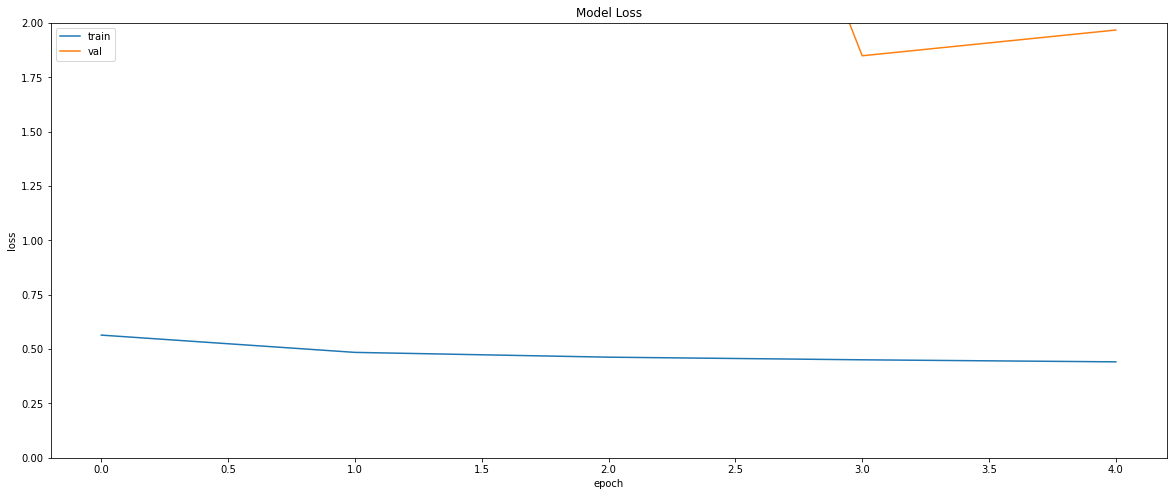

In [ ]:
plt.figure(figsize=(20,8))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.ylim([0,2])
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
random_val_samples = val_generator.__next__()
val_image_samples = random_val_samples[0]
val_mask_samples = random_val_samples[1]
predicted_masks = model.predict(val_image_samples)

predicted_masks[predicted_masks >= 0.5] = 1
predicted_masks[predicted_masks < 0.5] = 0

1/1 [==============================] - 18s 18s/step


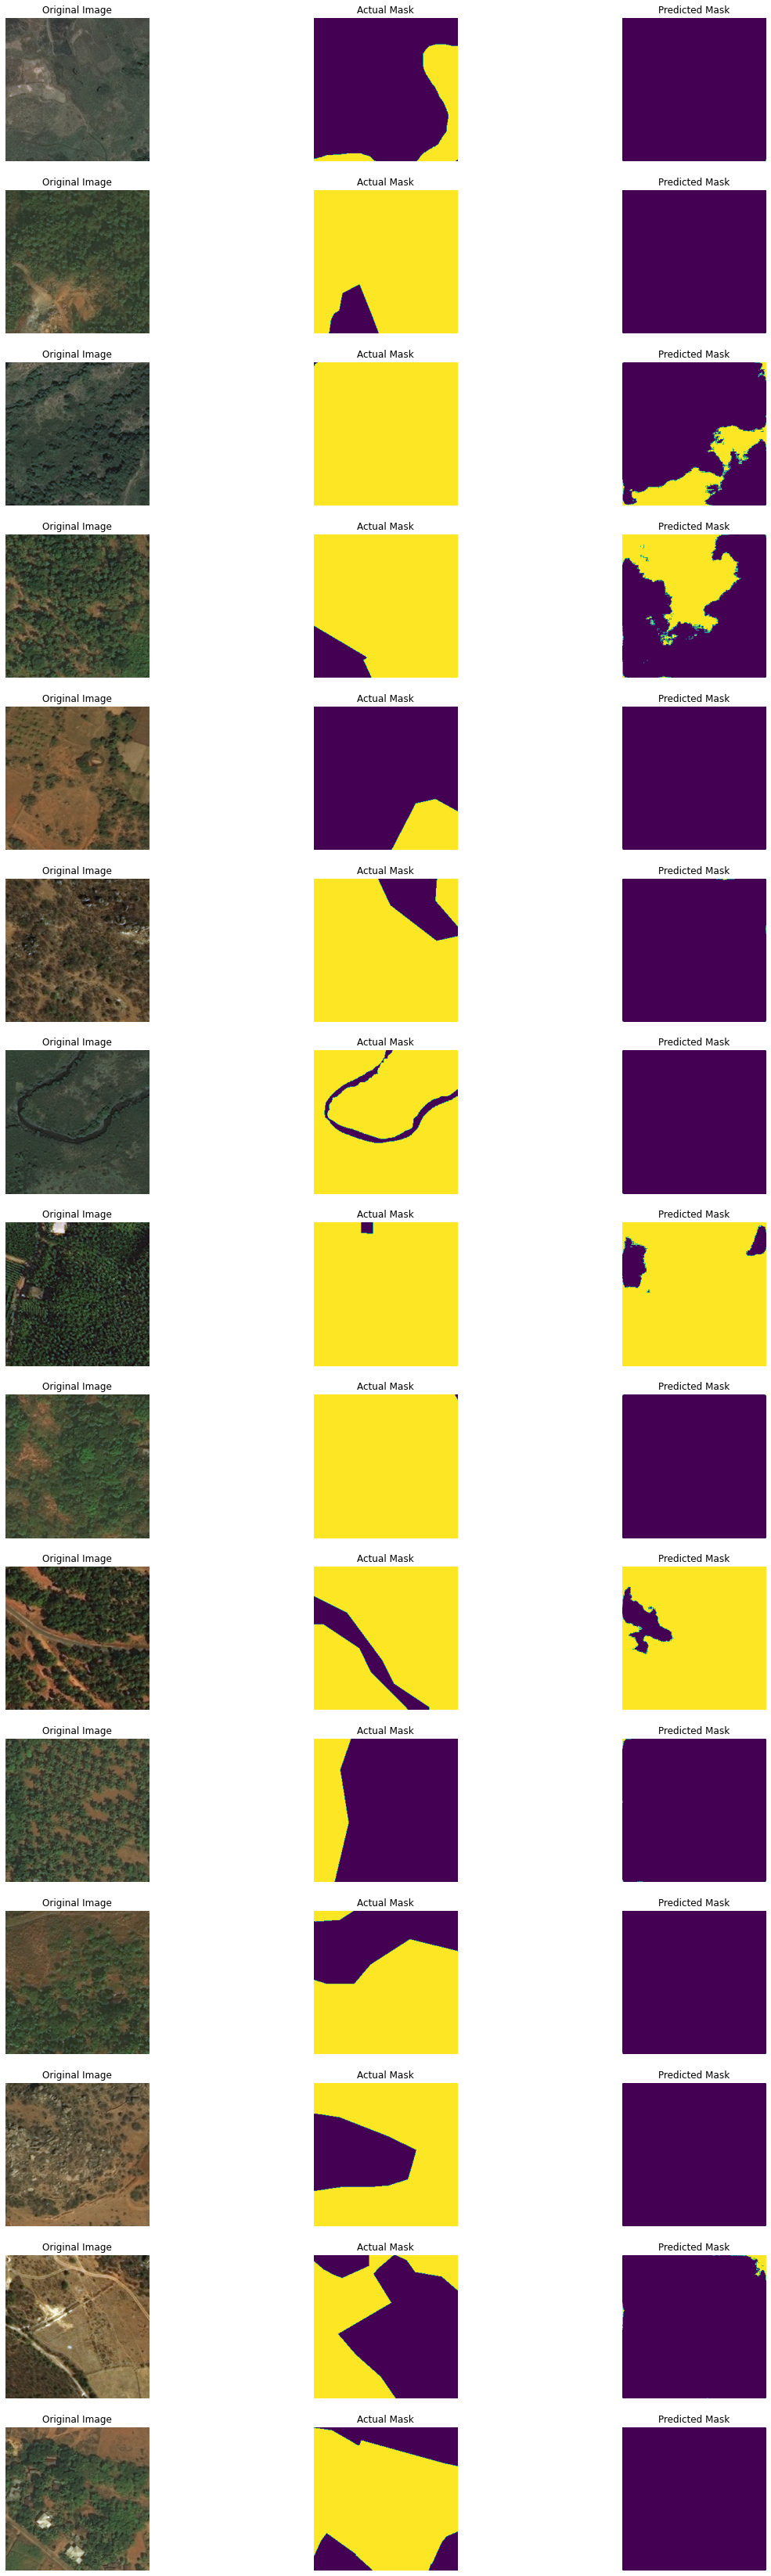

In [ ]:
f, axarr = plt.subplots(15,3,figsize=(20, 60))

for i in range(0,15):

    axarr[i,0].imshow(val_image_samples[i])
    axarr[i,0].title.set_text('Original Image')
    axarr[i,0].axis('off')
    axarr[i,1].imshow(val_mask_samples[i][:,:,0])
    axarr[i,1].title.set_text('Actual Mask')
    axarr[i,1].axis('off')
    axarr[i,2].imshow(predicted_masks[i][:,:,0])
    axarr[i,2].title.set_text('Predicted Mask')
    axarr[i,2].axis('off')